In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Users\\Muhammad Raihan\\Downloads\\Obfuscated-MalMem2022.csv") #DM--> Dataset Malware

In [3]:
#Feature Selection
features = DM.drop(['Category','Class'],axis=1).columns.tolist()
# Target variable
y = DM['Class'].values

In [4]:
# Memilih 5% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('Class').apply(lambda x: x.sample(frac=0.05)).reset_index(drop=True)

In [5]:
for i, column_name in enumerate(features):
    print(f"{i+1:3} {column_name:40} {sampled_data[column_name].count():<15} {sampled_data[column_name].dtype}")

  1 pslist.nproc                             2930            int64
  2 pslist.nppid                             2930            int64
  3 pslist.avg_threads                       2930            float64
  4 pslist.nprocs64bit                       2930            int64
  5 pslist.avg_handlers                      2930            float64
  6 dlllist.ndlls                            2930            int64
  7 dlllist.avg_dlls_per_proc                2930            float64
  8 handles.nhandles                         2930            int64
  9 handles.avg_handles_per_proc             2930            float64
 10 handles.nport                            2930            int64
 11 handles.nfile                            2930            int64
 12 handles.nevent                           2930            int64
 13 handles.ndesktop                         2930            int64
 14 handles.nkey                             2930            int64
 15 handles.nthread                          2930     

In [6]:
# Mencoba mencari threshold terbaik pada fitur yang dipilih
hasil_threshold = []

def Thresholding(threshold, feature):
    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # menentukan TP, TN, FP, FN
    from sklearn.metrics import confusion_matrix

    # Untuk BenignDataThreshold
    y_true_benign = ["Benign"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["Class"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Malware"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["Class"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp/(tp+fp) if (tp+fp) != 0 else 0
    RecallThreshold = tp/(tp+fn) if (tp+fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold*RecallThreshold)/(PrecisionThreshold+RecallThreshold)) if (PrecisionThreshold+RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp+tn)/(tp+fp+tn+fn) if (tp+fp+tn+fn) != 0 else 0

    matrix = [[feature, threshold], [PrecisionThreshold], [RecallThreshold], [F1ScoreThreshold], [AccuracyThreshold]]
    hasil_threshold.append(matrix)

for feature in tqdm(features, desc='Progress'):
    Max = sampled_data[feature].max()
    Min = sampled_data[feature].min()

    for x in range(int(Min), int(Max + 1)):
        Thresholding(x, feature)

print(hasil_threshold)

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [25:47<00:00, 28.14s/it]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=2000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [7]:
winner = [['', 0], [0], [0], [0], [0]]  # Format: [[feature, threshold], [precision], [recall], [f1-score], [accuracy]]

for result in hasil_threshold:
    if result[1][0] > winner[4][0]:
        winner = result

print(f"Dengan fitur {winner[0][0]} dan threshold {winner[0][1]}, menghasilkan akurasi {winner[4][0]} yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.")


Dengan fitur callbacks.ngeneric dan threshold 8, menghasilkan akurasi 0.5 yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.


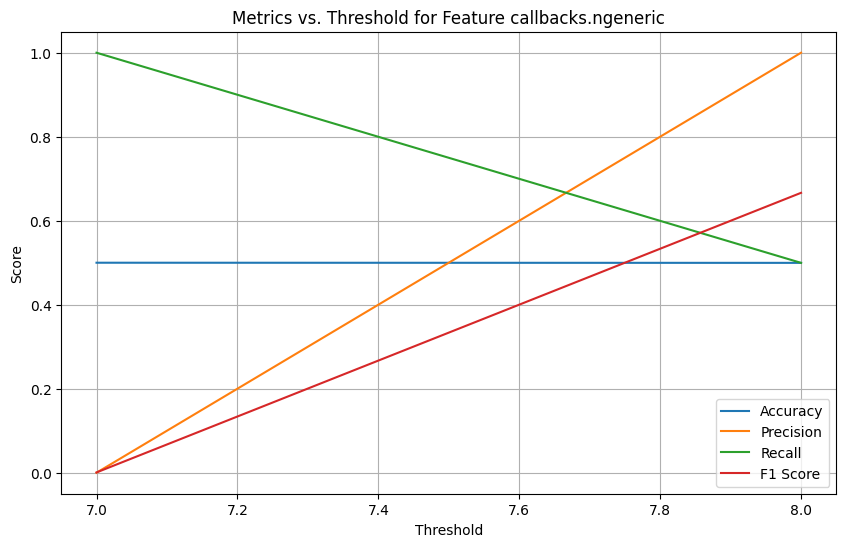

In [8]:
# Mendapatkan fitur pemenang dan thresholdnya
winner_feature, winner_threshold = winner[0]

# Memfilter hasil threshold untuk fitur pemenang
winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

# Pisahkan hasil menjadi list berdasarkan feature dan kolom
thresholds, precision, recall, f1_score, accuracy = [], [], [], [], []
for result in winner_results:
    thresholds.append(result[0][1])
    precision.append(result[1][0])
    recall.append(result[2][0])
    f1_score.append(result[3][0])
    accuracy.append(result[4][0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy, label='Accuracy')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1_score, label='F1 Score')

plt.title(f'Metrics vs. Threshold for Feature {winner_feature}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()